# Seasonality

Loading data from matlab struct, reformatted in matlab from matlab table and then looking at the seasonality of the WIM data at Ceneri. Initially the years 2014-2016 were looked at and then due to gaps in data only 2014 was used to look at daily/hourly seasonality.

In [1]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

Had to remove 'HH' column, has length of only one in the 

In [2]:
def load_table_from_struct(table_structure) -> pd.DataFrame():

    # get prepared data structure
    data = table_structure[0, 0]['table']['data']
    # get prepared column names
    data_cols = [name[0] for name in table_structure[0, 0]['columns'][0]]

    # create dict out of original table
    table_dict = {}
    for colidx in range(len(data_cols)):
        if data_cols[colidx] != 'HH':
            table_dict[data_cols[colidx]] = [val[0] for val in data[0, 0][0, colidx]]
    
    return pd.DataFrame(table_dict)

In [3]:
#Loading matrices from struct in matlab

dfs = []

for year in range(2014, 2017):
    struct = scipy.io.loadmat('Ceneri_%d_struct.mat' % year)
    dfs.append(load_table_from_struct(struct['Ceneri_struct']))
    
df = pd.concat(dfs, ignore_index=True)

In [4]:
df.shape

(4582618, 35)

In [6]:
df['T'].unique()

array([0], dtype=int64)

The 

In [7]:
df = df[['JJJJMMTT', 'ZST', 'FS', 'HHMMSS', 'CS']]
df['HHMMSS'] = df['HHMMSS'].astype(str) 

In [8]:
df['HH'] = df['HHMMSS'].str[:-4]

In [9]:
df['MMSS'] = df['HHMMSS'].str[-4:]

In [10]:
df['MM'] = df['MMSS'].str[:-2]

In [11]:
df.head()

,JJJJMMTT,ZST,FS,HHMMSS,CS,HH,MMSS,MM
0,20140101,408,4,2112,8,,2112,21
1,20140101,408,3,5554,3,,5554,55
2,20140101,408,3,10333,3,1,0333,03
3,20140101,408,4,14034,10,1,4034,40
4,20140101,408,4,15724,1,1,5724,57


In [13]:
df = df.replace(r'', np.nan, regex=True)

In [14]:
df = df.fillna(0)
df['HH'] = df['HH'].astype(int)
df['MM'] = df['MM'].astype(int)

In [15]:
df.head()

,JJJJMMTT,ZST,FS,HHMMSS,CS,HH,MMSS,MM
0,20140101,408,4,2112,8,0,2112,21
1,20140101,408,3,5554,3,0,5554,55
2,20140101,408,3,10333,3,1,0333,3
3,20140101,408,4,14034,10,1,4034,40
4,20140101,408,4,15724,1,1,5724,57


Now that the hour and minute are seperated it can be used to count the total occurances of trucks per hour/day to determine if there is seasonality in the daily signal.

In [16]:
df['Date'] = df['JJJJMMTT'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [17]:
df = df.drop(columns=['JJJJMMTT'])

In [18]:
df.head()

,ZST,FS,HHMMSS,CS,HH,MMSS,MM,Date
0,408,4,2112,8,0,2112,21,2014-01-01
1,408,3,5554,3,0,5554,55,2014-01-01
2,408,3,10333,3,1,0333,3,2014-01-01
3,408,4,14034,10,1,4034,40,2014-01-01
4,408,4,15724,1,1,5724,57,2014-01-01


In [20]:
df_day = df.groupby('Date', as_index=True).MM.agg('sum')

In [21]:
df_day.head()

Date
2014-01-01    11537
2014-01-02    58053
2014-01-03    73842
2014-01-04    48463
2014-01-05    17793
Name: MM, dtype: int32

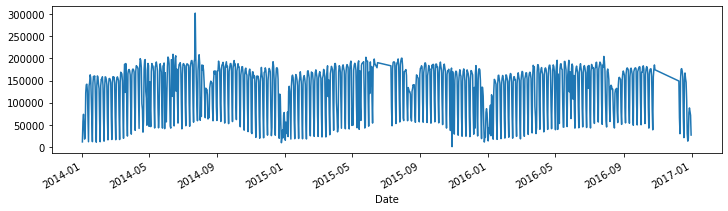

In [22]:
df_day.plot(figsize=(12,3))

Given the large gaps in data in 2015 and 2017, while there seems to be seasonal behavior on the yearly level, let's look specifically at 2014.

In [23]:
df_2014 = df_day.loc['2014-01-01':'2014-12-31']

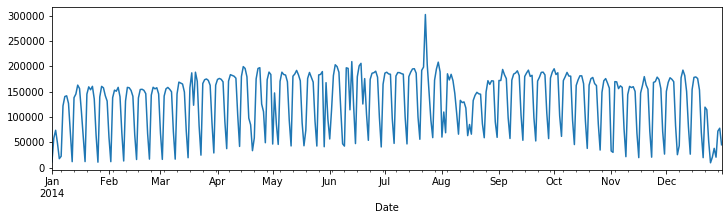

In [24]:
df_2014.plot(figsize=(12,3))

Below shows the weekly seasonality.

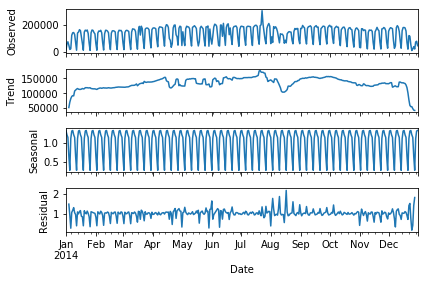

In [26]:
result = seasonal_decompose(df_2014, model='multiplicative')
result.plot()
pyplot.show()

Now we want to look at seasonality when the hour is incorporated.

In [27]:
df.head()

,ZST,FS,HHMMSS,CS,HH,MMSS,MM,Date
0,408,4,2112,8,0,2112,21,2014-01-01
1,408,3,5554,3,0,5554,55,2014-01-01
2,408,3,10333,3,1,0333,3,2014-01-01
3,408,4,14034,10,1,4034,40,2014-01-01
4,408,4,15724,1,1,5724,57,2014-01-01


In [28]:
df['Date'] += pd.to_timedelta(df.HH, unit='h')

In [29]:
df_day_hour = df.groupby('Date', as_index=True).MM.agg('sum')

In [31]:
df_2014_hour = df_day_hour.loc['2014-01-01 00:00:00':'2014-12-31 23:00:00']

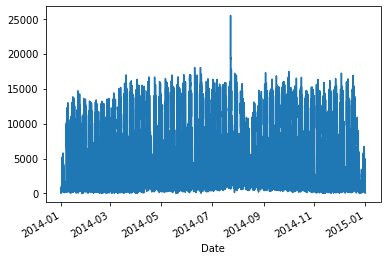

In [34]:
df_2014_hour.plot()

Below shows the 2014 seasonality by day.

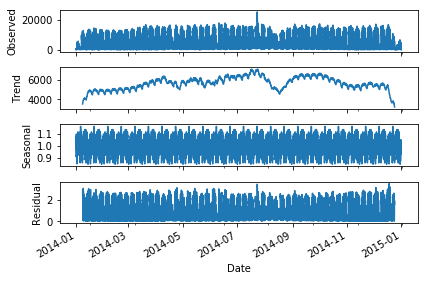

In [37]:
result = seasonal_decompose(df_2014_hour, model='multiplicative', freq=365)
result.plot()
pyplot.show()